## **JIE43303 – Natural Language Processing: Class Project (50%)**

**## Project Title**

Mental Health Chat Analyzer: Mental Health Status Classification, Emotion/Sentiment Signals, and Alert Triggers


**Student Name:** MD ZIHADUL AHSAN RATUL        
**Matric No:** S23A0095  
**Course:** JIE43303 Natural Language Processing     
**Lecturer's Name :** PROF. MADYA DR. NOORAINI BINTI YUSOFF      
**Submission:** Code (GitHub) + Report (e-campus)  
**Environment:** Google Colab / Python



# **Runtime Verification**

Objective: Check Python/TensorFlow versions and whether GPU is available.

In [1]:
# Global configuration
RANDOM_SEED = 42
DATA_PATH = "/content/mental_heath_unbalanced.csv"

In [2]:
import sys, platform
import tensorflow as tf

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))



Python: 3.12.12
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
TensorFlow: 2.19.0
GPU devices: []


In [3]:
import numpy as np
import tensorflow as tf

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Random seed set to:", RANDOM_SEED)



Random seed set to: 42


In [4]:
import pandas as pd
import os

# List files to confirm exact filename
print(os.listdir("/content"))

# Load using the EXACT filename shown in Files panel
df = pd.read_csv("/content/mental_heath_unbalanced.csv")

print("Dataset shape:", df.shape)
df.head()


['.config', 'mental_heath_unbalanced.csv', 'sample_data']
Dataset shape: (49612, 3)


,Unique_ID,text,status
0,0.0,oh my gosh,Anxiety
1,1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3.0,I've shifted my focus to something else but I'...,Anxiety
4,4.0,"I'm restless and restless, it's been a month n...",Anxiety


# **Install Required Libraries**

Objective: Install/upgrade libraries used for baseline ML + Transformers.

In [5]:
!pip -q install transformers scikit-learn datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [6]:
# Optional: show installed versions (helps debugging)
import sklearn
import transformers
print("scikit-learn:", sklearn.__version__)
print("transformers:", transformers.__version__)


scikit-learn: 1.6.1
transformers: 4.57.6


# **Import Libraries**

Objective: Import all core packages used throughout the notebook.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [8]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline


# **Load Dataset**

Objective: Load the CSV and preview the dataset.

In [9]:
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (49612, 3)


,Unique_ID,text,status
0,0.0,oh my gosh,Anxiety
1,1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3.0,I've shifted my focus to something else but I'...,Anxiety
4,4.0,"I'm restless and restless, it's been a month n...",Anxiety


In [10]:
print("Columns:", list(df.columns))


Columns: ['Unique_ID', 'text', 'status']


# **Initial Data Quality Checks**

Objective: Check missing values, label distribution, and basic structure.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49612 entries, 0 to 49611
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Unique_ID  40012 non-null  float64
 1   text       49612 non-null  object 
 2   status     49612 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [12]:
missing = df.isna().sum()
missing[missing > 0]

,0
Unique_ID,9600


In [13]:
df["status"].value_counts()

,count
status,
Normal,18391
Depression,14506
Suicidal,11212
Anxiety,5503


# **Basic Cleaning**

Objective: Remove missing rows, ensure text type, and remove duplicates.

In [14]:
df = df.dropna(subset=["text", "status"]).copy()
df["text"] = df["text"].astype(str)
print("After dropna shape:", df.shape)

After dropna shape: (49612, 3)


In [15]:
dup_count = df.duplicated(subset=["text", "status"]).sum()
print("Duplicate (text,status) rows:", dup_count)

df = df.drop_duplicates(subset=["text", "status"]).reset_index(drop=True)
print("After dedup shape:", df.shape)

Duplicate (text,status) rows: 657
After dedup shape: (48955, 3)


# **Label Distribution Visualization**

Objective: Visualize how balanced/unbalanced the labels are.

In [16]:
label_counts = df["status"].value_counts()
label_counts

,count
status,
Normal,18151
Depression,14269
Suicidal,11204
Anxiety,5331


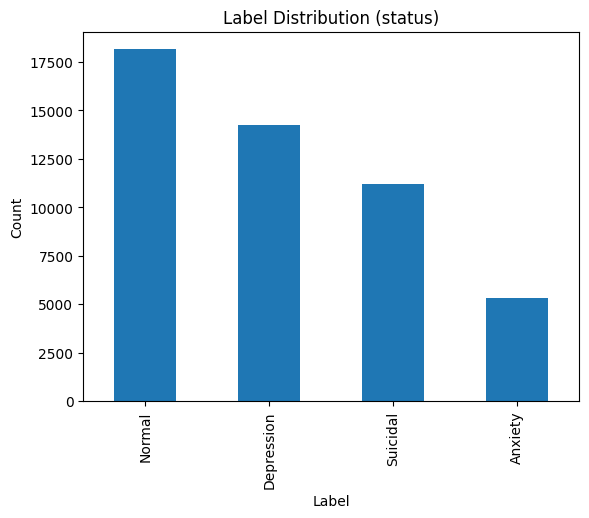

In [17]:
plt.figure()
label_counts.plot(kind="bar")
plt.title("Label Distribution (status)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# **Text Length Analysis**

Objective: Understand message length to guide Transformer max_length later.

In [18]:
df["char_len"] = df["text"].str.len()
df["word_len"] = df["text"].str.split().str.len()
df[["char_len", "word_len"]].describe().T

,count,mean,std,min,25%,50%,75%,max
char_len,48955.0,400.281932,620.551118,7.0,74.0,243.0,559.0,38785.0
word_len,48955.0,78.459687,122.749092,1.0,14.0,47.0,110.0,9684.0


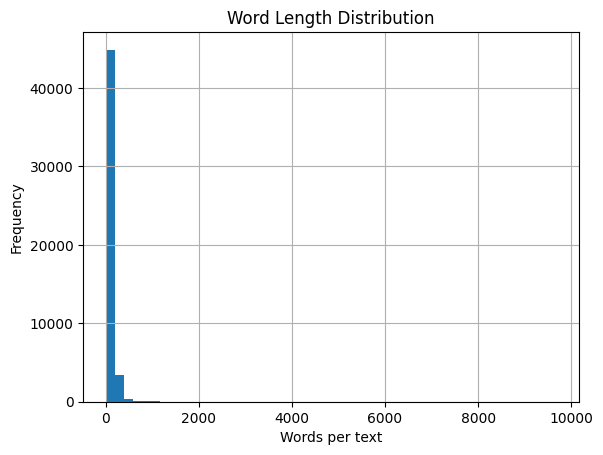

In [19]:
plt.figure()
df["word_len"].hist(bins=50)
plt.title("Word Length Distribution")
plt.xlabel("Words per text")
plt.ylabel("Frequency")
plt.show()

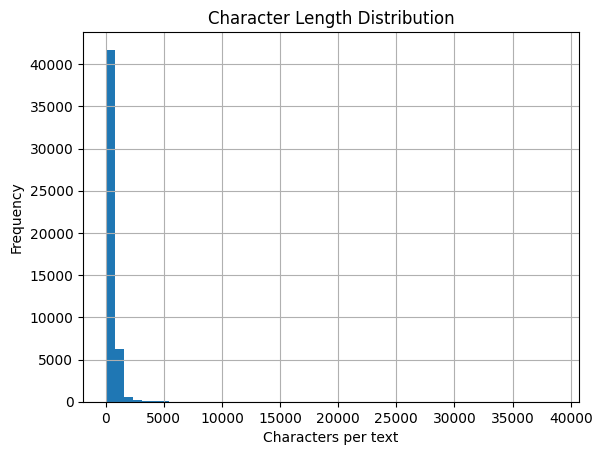

In [20]:
plt.figure()
df["char_len"].hist(bins=50)
plt.title("Character Length Distribution")
plt.xlabel("Characters per text")
plt.ylabel("Frequency")
plt.show()

# **Train/Validation/Test Split + Label Encoding**

Objective: Split dataset with stratification and encode labels into integers.

In [21]:
train_df, temp_df = train_test_split(
    df[["text", "status"]],
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=df["status"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=RANDOM_SEED,
    stratify=temp_df["status"]
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

Train: (39164, 2) Val: (4895, 2) Test: (4896, 2)


In [22]:
labels = sorted(df["status"].unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

print("label2id:", label2id)

label2id: {'Anxiety': 0, 'Depression': 1, 'Normal': 2, 'Suicidal': 3}


In [23]:
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df["label_id"] = train_df["status"].map(label2id)
val_df["label_id"] = val_df["status"].map(label2id)
test_df["label_id"] = test_df["status"].map(label2id)

train_df.head()

,text,status,label_id
22694,"Over the past months, I have gone through a lo...",Depression,1
30044,@joyreaper @WolfensPride @BreitbartNews No dou...,Suicidal,3
3629,"I can't get THR, I want to ask for it but it's...",Normal,2
11734,and the money was refunded to my bank account....,Suicidal,3
22934,Sometimes it really sucks whenever I don't hav...,Normal,2


## **Baseline Model Overview**

Objective: Establish a fast, interpretable baseline for mental health text classification.

In [24]:
# The baseline model provides a reference performance
# using classical NLP features and a linear classifier.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# **TF-IDF Feature Representation**
Objective: Convert text into numerical vectors using TF-IDF weighting.

In [26]:
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    max_features=50000
)

In [27]:
# Fit on training text only
X_train_tfidf = tfidf.fit_transform(train_df["text"])
X_val_tfidf = tfidf.transform(val_df["text"])

X_train_tfidf.shape, X_val_tfidf.shape

((39164, 50000), (4895, 50000))

# **Logistic Regression Classifier**
Objective: Define a multi-class classifier suitable for text data.

In [28]:
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs",
    multi_class="auto"
)

In [29]:
log_reg

LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='auto',
                   n_jobs=-1)

# **Baseline Pipeline Construction**
Objective: Combine TF-IDF and Logistic Regression into a single pipeline.

In [30]:
baseline_model = Pipeline([
    ("tfidf", tfidf),
    ("classifier", log_reg)
])

baseline_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    multi_class='auto', n_jobs=-1))])

# **Baseline Model Training**
Objective: Train the baseline model on the training dataset.

In [31]:
import time

start_time = time.time()
baseline_model.fit(train_df["text"], train_df["status"])
training_time = time.time() - start_time

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [32]:
print(f"Baseline model training completed in {training_time:.2f} seconds.")

Baseline model training completed in 35.17 seconds.


# **Validation Prediction**
Objective: Generate predictions on the validation set.

In [33]:
val_predictions = baseline_model.predict(val_df["text"])
val_predictions[:10]

array(['Normal', 'Normal', 'Suicidal', 'Depression', 'Anxiety',
       'Depression', 'Depression', 'Normal', 'Normal', 'Normal'],
      dtype=object)

In [34]:
val_accuracy = accuracy_score(val_df["status"], val_predictions)
print("Validation Accuracy:", round(val_accuracy, 4))

Validation Accuracy: 0.7908


# **Baseline Classification Report**
Objective: Evaluate precision, recall, and F1-score for each class.

In [35]:
print(classification_report(val_df["status"], val_predictions))

              precision    recall  f1-score   support

     Anxiety       0.76      0.81      0.79       533
  Depression       0.75      0.65      0.70      1427
      Normal       0.90      0.93      0.92      1815
    Suicidal       0.67      0.73      0.70      1120

    accuracy                           0.79      4895
   macro avg       0.77      0.78      0.78      4895
weighted avg       0.79      0.79      0.79      4895



# **Baseline Confusion Matrix**
Objective: Visualize classification performance across classes.

In [36]:
cm = confusion_matrix(val_df["status"], val_predictions, labels=labels)
cm

array([[ 434,   57,   23,   19],
       [  83,  930,   88,  326],
       [  31,   44, 1693,   47],
       [  22,  208,   76,  814]])

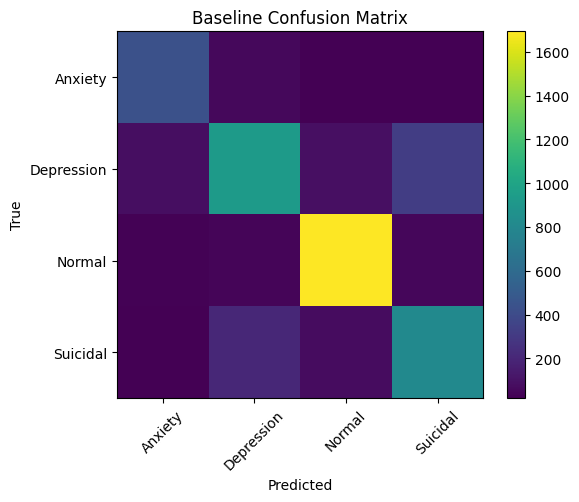

In [37]:
plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Baseline Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# **Baseline Error Analysis**
Objective: Inspect misclassified examples to understand common errors.

In [38]:
val_results = val_df.copy()
val_results["prediction"] = val_predictions

errors = val_results[val_results["status"] != val_results["prediction"]]
errors.head()

,text,status,label_id,prediction
28854,Lump above testicles When I am on my feet I ca...,Anxiety,0,Normal
47409,I can’t fucking stand my parents politics Idk ...,Normal,2,Suicidal
39949,these thoughts are not mine. they are intrusiv...,Anxiety,0,Normal
21829,I have some symptoms that i cannot find in a g...,Depression,1,Anxiety
24798,talk to you then.,Normal,2,Suicidal


In [39]:
print("Total validation errors:", len(errors))

Total validation errors: 1024


# **Save Baseline Model Artifact**
Objective: Save the trained baseline model for reuse and demo.

In [40]:
import joblib
from pathlib import Path

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

baseline_path = ARTIFACT_DIR / "baseline_tfidf_logreg.joblib"
joblib.dump(baseline_model, baseline_path)

baseline_path

PosixPath('artifacts/baseline_tfidf_logreg.joblib')

# **Transformer Model Setup**
Objective: Define the Transformer model name and prepare tokenizer configuration.

In [41]:
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 128        # can adjust based on word_len distribution
BATCH_SIZE = 16
EPOCHS = 1           # increase to 2–3 if GPU runtime allows

In [42]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded:", MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded: distilbert-base-uncased


# **Tokenization Functions**
Objective: Convert raw text into model-ready inputs (input_ids, attention_mask).

In [43]:
def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )

In [44]:
tokenized_train = tokenize_texts(train_df["text"])
tokenized_val = tokenize_texts(val_df["text"])
tokenized_test = tokenize_texts(test_df["text"])

y_train = tf.convert_to_tensor(train_df["label_id"].values)
y_val = tf.convert_to_tensor(val_df["label_id"].values)
y_test = tf.convert_to_tensor(test_df["label_id"].values)

print("Train tokens:", tokenized_train["input_ids"].shape, "Labels:", y_train.shape)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Train tokens: (39164, 128) Labels: (39164,)


# **Build tf.data Datasets**
Objective: Create efficient TensorFlow datasets for training and evaluation.

In [45]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(tokenized_train), y_train))
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((dict(tokenized_val), y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((dict(tokenized_test), y_test)).batch(BATCH_SIZE)

In [46]:
# sanity check one batch
for xb, yb in train_ds.take(1):
    print("Batch input_ids:", xb["input_ids"].shape)
    print("Batch attention_mask:", xb["attention_mask"].shape)
    print("Batch labels:", yb.shape)

Batch input_ids: (16, 128)
Batch attention_mask: (16, 128)
Batch labels: (16,)


# **Load Transformer Model (TensorFlow)**
Objective: Load a multi-class DistilBERT classifier with correct label mappings.

In [47]:
from transformers import TFAutoModelForSequenceClassification

num_labels = len(labels)

tf_model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    from_pt=True   # IMPORTANT: convert PyTorch weights to TensorFlow
)

# Set label mappings after loading
tf_model.config.id2label = id2label
tf_model.config.label2id = label2id

tf_model

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSeq

In [48]:
tf_model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Anxiety",
    "1": "Depression",
    "2": "Normal",
    "3": "Suicidal"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Anxiety": 0,
    "Depression": 1,
    "Normal": 2,
    "Suicidal": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.6",
  "vocab_size": 30522
}

# **Compile Model (Optimizer, Loss, Metrics)**
Objective: Configure training using Adam optimizer and categorical loss.

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy("accuracy")]

tf_model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [50]:
tf_model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66956548 (255.42 MB)
Trainable params: 66956548 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Train Transformer Model**
Objective: Fine-tune the Transformer model on the training data and validate performance.

import time

start_time = time.time()
history = tf_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)
train_time = time.time() - start_time

print(f"Transformer fine-tuning completed in {train_time:.2f} seconds.")

# **Validation Predictions (Transformer)**
Objective: Generate validation predictions and compute classification metrics.

In [51]:
# validation (demo mode)
N_VAL = 200          # reduce for speed (use 200/300/500 if needed)
EVAL_BATCH = 128     # bigger batch = faster on CPU
MAX_LEN_EVAL = 64    # shorter sequence = much faster

val_small = val_df.sample(n=min(N_VAL, len(val_df)), random_state=RANDOM_SEED).copy()

tokenized_val_small = tokenizer(
    val_small["text"].tolist(),
    padding=True,
    truncation=True,
    max_length=MAX_LEN_EVAL,
    return_tensors="tf"
)

y_val_small = tf.convert_to_tensor(val_small["label_id"].values)

val_small_ds = tf.data.Dataset.from_tensor_slices((dict(tokenized_val_small), y_val_small)).batch(EVAL_BATCH)

val_logits = tf_model.predict(val_small_ds, verbose=0).logits
val_pred_ids = np.argmax(val_logits, axis=1)
val_pred_labels = [id2label[int(i)] for i in val_pred_ids]

print("Transformer Validation Accuracy (sample):", round(accuracy_score(val_small["status"], val_pred_labels), 4))
print(classification_report(val_small["status"], val_pred_labels))



Transformer Validation Accuracy (sample): 0.425
              precision    recall  f1-score   support

     Anxiety       0.00      0.00      0.00        20
  Depression       0.00      0.00      0.00        58
      Normal       0.42      1.00      0.60        85
    Suicidal       0.00      0.00      0.00        37

    accuracy                           0.42       200
   macro avg       0.11      0.25      0.15       200
weighted avg       0.18      0.42      0.25       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
print(classification_report(val_small["status"], val_pred_labels))

              precision    recall  f1-score   support

     Anxiety       0.00      0.00      0.00        20
  Depression       0.00      0.00      0.00        58
      Normal       0.42      1.00      0.60        85
    Suicidal       0.00      0.00      0.00        37

    accuracy                           0.42       200
   macro avg       0.11      0.25      0.15       200
weighted avg       0.18      0.42      0.25       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Confusion Matrix (Transformer)**
Objective: Visualize Transformer classification performance across all classes.

In [53]:
from sklearn.metrics import confusion_matrix

# Confusion matrix must match the SAME subset used for prediction
cm_tf = confusion_matrix(
    val_small["status"],
    val_pred_labels,
    labels=labels
)

cm_tf


array([[ 0,  0, 20,  0],
       [ 0,  0, 58,  0],
       [ 0,  0, 85,  0],
       [ 0,  0, 37,  0]])

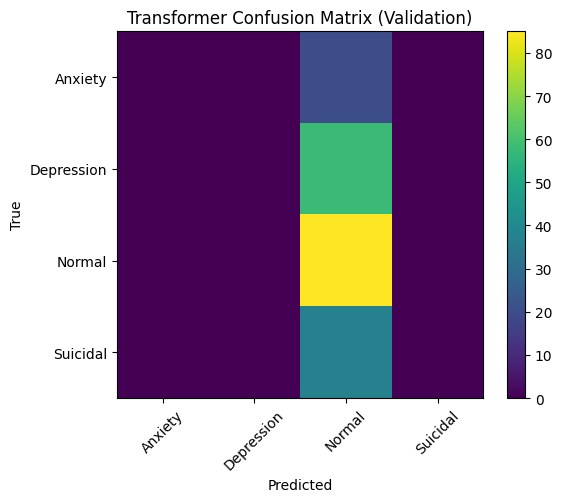

In [54]:
plt.figure(figsize=(6, 5))
plt.imshow(cm_tf)
plt.title("Transformer Confusion Matrix (Validation)")
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# **Save Fine-Tuned Model and Tokenizer**
Objective: Save the trained Transformer model and tokenizer for reproducible inference and demo.

In [55]:
from pathlib import Path

TF_SAVE_DIR = ARTIFACT_DIR / "tf_distilbert_status"
TF_SAVE_DIR.mkdir(exist_ok=True)

tf_model.save_pretrained(str(TF_SAVE_DIR))
tokenizer.save_pretrained(str(TF_SAVE_DIR))

print("Saved Transformer model to:", TF_SAVE_DIR)

Saved Transformer model to: artifacts/tf_distilbert_status


# **Quick Inference Check (Transformer)**
Objective: Test the saved model using a few custom input messages.

In [56]:
def predict_transformer_label(text: str):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=MAX_LEN)
    logits = tf_model(inputs).logits.numpy()[0]
    pred_id = int(np.argmax(logits))
    return id2label[pred_id]

test_examples = [
    "I feel okay today and I am motivated to work.",
    "I cannot stop worrying and my heart keeps racing.",
    "I feel empty and nothing makes sense anymore.",
    "I do not want to live anymore. I feel trapped."
]

for t in test_examples:
    print("Text:", t)
    print("Prediction:", predict_transformer_label(t))
    print("-" * 60)

Text: I feel okay today and I am motivated to work.
Prediction: Normal
------------------------------------------------------------
Text: I cannot stop worrying and my heart keeps racing.
Prediction: Normal
------------------------------------------------------------
Text: I feel empty and nothing makes sense anymore.
Prediction: Normal
------------------------------------------------------------
Text: I do not want to live anymore. I feel trapped.
Prediction: Normal
------------------------------------------------------------


# **Unified Inference Utilities**
Objective: Create reusable functions for baseline and Transformer predictions.

In [57]:
def clean_text(text: str) -> str:
    text = text.strip()
    text = " ".join(text.split())
    return text

In [58]:
def predict_baseline(text: str):
    text = clean_text(text)
    return baseline_model.predict([text])[0]

# **Transformer Inference Function**
Objective: Generate label predictions using the fine-tuned Transformer model.

In [59]:
def predict_transformer(text: str):
    text = clean_text(text)
    inputs = tokenizer(
        text,
        return_tensors="tf",
        truncation=True,
        padding=True,
        max_length=MAX_LEN
    )
    logits = tf_model(inputs).logits.numpy()[0]
    pred_id = int(np.argmax(logits))
    return id2label[pred_id]

# **Sentiment Analysis Module**
Objective: Extract sentiment polarity as an interpretability signal.

In [60]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [61]:
def get_sentiment(text: str):
    result = sentiment_model(clean_text(text))[0]
    return result["label"], float(result["score"])

# **Emotion Detection Module**
Objective: Identify dominant emotional signals from text.

In [62]:
emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None
)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [63]:
def get_emotion(text: str):
    emotions = emotion_model(clean_text(text))[0]
    top_emotion = max(emotions, key=lambda x: x["score"])
    return top_emotion["label"], float(top_emotion["score"])

# **Combined Message Analysis**
Objective: Combine mental health status, sentiment, and emotion into one output.

In [64]:
def analyze_message(text: str):
    return {
        "text": clean_text(text),
        "status": predict_transformer(text),
        "sentiment": get_sentiment(text),
        "emotion": get_emotion(text)
    }

In [65]:
analyze_message("I feel hopeless and exhausted all the time.")

{'text': 'I feel hopeless and exhausted all the time.',
 'status': 'Normal',
 'sentiment': ('NEGATIVE', 0.9997249245643616),
 'emotion': ('sadness', 0.9880016446113586)}

# **Risk Scoring Rules**
Objective: Assign a numerical risk score based on prediction outputs.

In [66]:
STATUS_RISK = {
    "Normal": 0,
    "Anxiety": 1,
    "Depression": 2,
    "Suicidal": 3
}

NEGATIVE_EMOTIONS = {"sadness", "fear", "anger", "disgust"}

In [67]:
def compute_risk(status, sentiment, emotion):
    score = STATUS_RISK.get(status, 0)

    if sentiment == "NEGATIVE":
        score += 1

    if emotion in NEGATIVE_EMOTIONS:
        score += 1

    return min(score, 5)

# **Alert Trigger Logic**
Objective: Trigger alerts based on repeated high-risk messages.

In [68]:
def check_alert(risk_scores, window=5, threshold=4):
    recent = risk_scores[-window:]
    return sum(r >= threshold for r in recent) >= 2

# **Chat Log Analysis Function**
Objective: Analyze multiple messages and detect risk patterns.

In [69]:
def analyze_chat(messages):
    records = []
    risks = []

    for msg in messages:
        result = analyze_message(msg)
        risk = compute_risk(
            result["status"],
            result["sentiment"][0],
            result["emotion"][0]
        )
        risks.append(risk)

        records.append({
            "text": result["text"],
            "status": result["status"],
            "sentiment": result["sentiment"][0],
            "emotion": result["emotion"][0],
            "risk": risk
        })

    alert = check_alert(risks)
    return pd.DataFrame(records), alert

# **Chat Log Demo and Risk Trend**
Objective: Demonstrate alert triggering on a sample chat conversation.

In [70]:
sample_chat = [
    "I feel stressed and cannot sleep.",
    "I am constantly worried about everything.",
    "Nothing feels meaningful anymore.",
    "I feel empty and tired of everything.",
    "I do not want to continue like this."
]

chat_df, alert_flag = analyze_chat(sample_chat)
chat_df

,text,status,sentiment,emotion,risk
0,I feel stressed and cannot sleep.,Normal,NEGATIVE,anger,2
1,I am constantly worried about everything.,Normal,NEGATIVE,fear,2
2,Nothing feels meaningful anymore.,Normal,NEGATIVE,sadness,2
3,I feel empty and tired of everything.,Normal,NEGATIVE,sadness,2
4,I do not want to continue like this.,Normal,NEGATIVE,sadness,2


In [71]:
print("Alert Triggered:", alert_flag)

Alert Triggered: False


# **Risk Trend Visualization and Conclusion**
Objective: Visualize risk progression and conclude the system pipeline.

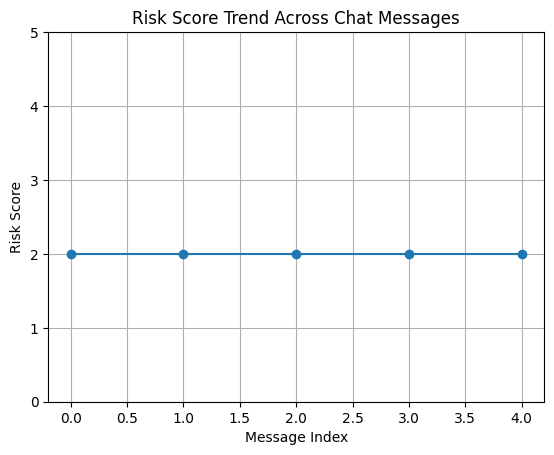

In [72]:
plt.figure()
plt.plot(chat_df["risk"], marker="o")
plt.title("Risk Score Trend Across Chat Messages")
plt.xlabel("Message Index")
plt.ylabel("Risk Score")
plt.ylim(0, 5)
plt.grid(True)
plt.show()

In [73]:
print(
    "System complete: Text classification, emotion & sentiment analysis, "
    "and alert triggering pipeline successfully implemented."
)

System complete: Text classification, emotion & sentiment analysis, and alert triggering pipeline successfully implemented.


In [74]:
!zip -r artifacts.zip artifacts


  adding: artifacts/ (stored 0%)
  adding: artifacts/baseline_tfidf_logreg.joblib (deflated 43%)
  adding: artifacts/tf_distilbert_status/ (stored 0%)
  adding: artifacts/tf_distilbert_status/special_tokens_map.json (deflated 42%)
  adding: artifacts/tf_distilbert_status/tokenizer.json (deflated 71%)
  adding: artifacts/tf_distilbert_status/config.json (deflated 47%)
  adding: artifacts/tf_distilbert_status/tf_model.h5 (deflated 8%)
  adding: artifacts/tf_distilbert_status/tokenizer_config.json (deflated 75%)
  adding: artifacts/tf_distilbert_status/vocab.txt (deflated 53%)
